174/174 [==============================] - 0s 947us/step


174/174 [==============================] - 0s 907us/step


174/174 [==============================] - 0s 802us/step


174/174 [==============================] - 0s 861us/step


174/174 [==============================] - 0s 906us/step


174/174 [==============================] - 0s 809us/step
0    51.659452
0    49.783550
0    38.528139
0    49.783550
0    52.236652
0    43.578644
Name: accuracy, dtype: float64


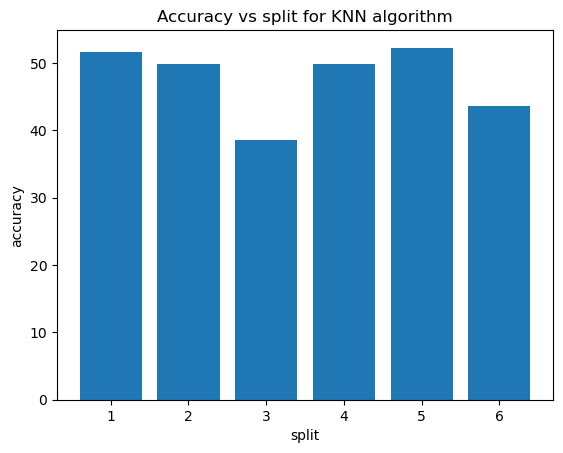

In [76]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import RidgeClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sktime.classification.deep_learning.mlp import MLPClassifier


from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from pyts.classification import *

from sktime.classification.sklearn import RotationForest
from sktime.classification.deep_learning.cnn import CNNClassifier
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.classification.deep_learning.fcn import FCNClassifier

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from backtesting.test import EURUSD, SMA
import pmdarima as pm

data = EURUSD.copy()
data


# data = pd.read_table('/Users/newuser/Projects/robust-algo-trader/data/EURUSD_H1_200702210000_202304242100.tsv')
# # remove the following columns <TICKVOL>, <VOL> and <SPREAD>
# data = data.drop(['<TICKVOL>', '<VOL>', '<SPREAD>'], axis=1)
# # rename the columns
# data = data.rename(columns={'<DATE>': 'Date',
#                                 '<TIME>': 'Time',
#                                 '<OPEN>': 'Open',
#                                 '<HIGH>': 'High',
#                                 '<LOW>': 'Low',
#                                 '<CLOSE>': 'Close'})
# # combine the date and time columns
# data['Date_Time'] = data['Date'] + ' ' + data['Time']
# # convert the date_time column to datetime
# data['Date_Time'] = pd.to_datetime(data['Date_Time'], format='%Y%m%d %H:%M:%S.%f')
# # remove the date and time columns
# data = data.drop(['Date', 'Time'], axis=1)
# data.index = data['Date_Time']


def BBANDS(data, n_lookback, n_std):
    """Bollinger bands indicator"""
    hlc3 = (data.High + data.Low + data.Close) / 3
    mean, std = hlc3.rolling(n_lookback).mean(), hlc3.rolling(n_lookback).std()
    upper = mean + n_std*std
    lower = mean - n_std*std
    return upper, lower


close = data.Close.values
sma10 = SMA(data.Close, 10)
sma20 = SMA(data.Close, 20)
sma50 = SMA(data.Close, 50)
sma100 = SMA(data.Close, 100)
upper, lower = BBANDS(data, 20, 2)

# Design matrix / independent features:

# Price-derived features
data['X_SMA10'] = (close - sma10) / close
data['X_SMA20'] = (close - sma20) / close
data['X_SMA50'] = (close - sma50) / close
data['X_SMA100'] = (close - sma100) / close

data['X_DELTA_SMA10'] = (sma10 - sma20) / close
data['X_DELTA_SMA20'] = (sma20 - sma50) / close
data['X_DELTA_SMA50'] = (sma50 - sma100) / close

# Indicator features
data['X_MOM'] = data.Close.pct_change(periods=2)
data['X_BB_upper'] = (upper - close) / close
data['X_BB_lower'] = (lower - close) / close
data['X_BB_width'] = (upper - lower) / close
# data['X_Sentiment'] = ~data.index.to_series().between('2017-09-27', '2017-12-14')

# Some datetime features for good measure
data['X_day'] = data.index.dayofweek
data['X_hour'] = data.index.hour

# data = data.dropna()
data = data.dropna().astype(float)


def get_X(data):
    """Return model design matrix X"""
    return data.filter(like='X').values


def get_y(data):
    """Return dependent variable y"""
    y = data.Close.pct_change(48).shift(-48)  # Returns after roughly two days
    # Devalue returns smaller than 0.4%
    y[y.between(-.004, .004)] = 0
    y[y > 0] = 1
    y[y < 0] = -1
    return y


def get_clean_Xy(df):
    """Return (X, y) cleaned of NaN values"""
    X = get_X(df)
    y = get_y(df).values
    isnan = np.isnan(y)
    X = X[~isnan]
    y = y[~isnan]
    return X, y



X, y = get_clean_Xy(data)
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=.5, random_state=0)

tscv = TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=None)

pred_score_list = []
for i, (train_index, test_index) in enumerate(tscv.split(X)):
    X_train = X[train_index]
    X_test = X[test_index]
    y_train = y[train_index]
    y_test = y[test_index]
    # Model the output based on 7 "nearest" examples
    # clf = KNeighborsClassifier(7)
    # clf = LogisticRegressionCV(max_iter=100_000, cv=5, random_state=0)
    # clf = DecisionTreeClassifier( random_state=0)
    # clf = MLPClassifier()
    # clf = RidgeClassifierCV()
    # clf = RandomForestClassifier()
    # clf = RadiusNeighborsClassifier(radius=100.0)
    # clf = GradientBoostingClassifier()
    
    # clf = TimeSeriesForest()
    # clf = LearningShapelets()
    
    # clf = RotationForest()
    # clf = TimeSeriesForestClassifier()
    # clf =  CNNClassifier(n_epochs=20,batch_size=4) 
    # clf =  FCNClassifier(n_epochs=20,batch_size=4) 
    clf =  MLPClassifier(n_epochs=20,batch_size=4) 
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    # # Fit your model
    # model = pm.auto_arima(train, seasonal=True, m=12)

    # # make your forecasts
    # forecasts = model.predict(test.shape[0])  # predict N steps into the future
    
    
    pred_score_list.append(
        pd.DataFrame({
            'accuracy': accuracy_score(y_test, y_pred)*100,
            'split': i+1,
            'Algorithm': 'KNN',
        }, index=[0]))

pred_score_df = pd.concat(pred_score_list)

print(pred_score_df['accuracy'])

# Plot a bar chart of accuracy vs split for each algorithm
plt.bar(pred_score_df["split"], pred_score_df["accuracy"], label=pred_score_df["Algorithm"][0])
plt.xlabel("split")
plt.ylabel("accuracy")
plt.title("Accuracy vs split for KNN algorithm")
plt.show()

# print('Classification accuracy: ', np.mean(y_test == y_pred))


In [ ]:
0    47.153465
0    46.658416
0    43.440594
0    51.361386
0    46.287129

In [ ]:
data.columns

In [ ]:
data = data.dropna()

In [93]:
data

,Open,High,Low,Close,Volume,X_SMA10,X_SMA20,X_SMA50,X_SMA100,X_DELTA_SMA10,X_DELTA_SMA20,X_DELTA_SMA50,X_MOM,X_BB_upper,X_BB_lower,X_BB_width,X_day,X_hour
2017-04-25 12:00:00,1.08879,1.08962,1.08866,1.08890,1005.0,0.000934,0.001711,0.005324,0.010199,0.000777,0.003613,0.004875,0.000928,0.000562,-0.004080,0.004641,1.0,12.0
2017-04-25 13:00:00,1.08888,1.09016,1.08797,1.09000,1340.0,0.001577,0.002481,0.005945,0.011034,0.000904,0.003463,0.005090,0.001093,-0.000265,-0.004834,0.004569,1.0,13.0
2017-04-25 14:00:00,1.08997,1.09328,1.08902,1.09281,3642.0,0.003550,0.004726,0.008085,0.013392,0.001176,0.003359,0.005307,0.003591,-0.002029,-0.007627,0.005599,1.0,14.0
2017-04-25 15:00:00,1.09284,1.09412,1.09198,1.09409,1651.0,0.004024,0.005558,0.008800,0.014344,0.001533,0.003243,0.005544,0.003752,-0.002038,-0.009311,0.007273,1.0,15.0
2017-04-25 16:00:00,1.09407,1.09499,1.09386,1.09492,966.0,0.004172,0.005938,0.009074,0.014882,0.001766,0.003136,0.005808,0.001931,-0.001560,-0.010578,0.009019,1.0,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-07 11:00:00,1.23390,1.23548,1.23386,1.23501,2203.0,-0.001970,-0.002386,-0.002976,-0.006345,-0.000416,-0.000590,-0.003369,-0.000040,0.004715,0.000050,0.004666,2.0,11.0
2018-02-07 12:00:00,1.23501,1.23508,1.23342,1.23422,2325.0,-0.002280,-0.002871,-0.003423,-0.006920,-0.000591,-0.000552,-0.003496,0.000259,0.005591,0.000244,0.005347,2.0,12.0
2018-02-07 13:00:00,1.23422,1.23459,1.23338,1.23372,2824.0,-0.002291,-0.003059,-0.003651,-0.007239,-0.000768,-0.000592,-0.003589,-0.001045,0.006103,0.000132,0.005971,2.0,13.0
2018-02-07 14:00:00,1.23374,1.23452,1.23238,1.23426,4065.0,-0.001483,-0.002393,-0.003053,-0.006728,-0.000909,-0.000660,-0.003675,0.000032,0.005613,-0.000739,0.006351,2.0,14.0


In [ ]:
EURUSD

In [92]:
%%time

from backtesting import Backtest, Strategy
from pyts.classification import KNeighborsClassifier


N_TRAIN = 400

class MLTrainOnceStrategy(Strategy):
    price_delta = .004  # 0.4%

    def init(self):        
        # Init our model, a kNN classifier
        self.clf = KNeighborsClassifier()

        # Train the classifier in advance on the first N_TRAIN examples
        df = self.data.df.iloc[:N_TRAIN]
        X, y = get_clean_Xy(df)
        self.clf.fit(X, y)

        # Plot y for inspection
        self.I(get_y, self.data.df, name='y_true')

        # Prepare empty, all-NaN forecast indicator
        self.forecasts = self.I(lambda: np.repeat(np.nan, len(self.data)), name='forecast')
        
    
    def next(self):
        # Skip the cold start period with too few values available
        if len(self.data) < N_TRAIN:
            return
        
        if (len(self.data)) % N_TRAIN == 0:
            # Train the classifier in advance on the first N_TRAIN examples
            # get all rows except the current one
            N_TRAIN_UPDATE = len(self.data) - 1
            
            df = self.data.df.iloc[:N_TRAIN_UPDATE]
            X, y = get_clean_Xy(df)
            self.clf.fit(X, y)
        
        # Forecast the next movement
        X = get_X(self.data.df.iloc[-1:])
        forecast = self.clf.predict(X)[0]

        # Update the plotted "forecast" indicator
        self.forecasts[-1] = forecast

        # If our forecast is upwards and we don't already hold a long position
        # place a long order for 20% of available account equity. Vice versa for short.
        # Also set target take-profit and stop-loss prices to be one price_delta
        # away from the current closing price.
        # Proceed only with out-of-sample data. Prepare some variables
        
        high, low, close = self.data.High, self.data.Low, self.data.Close
        current_time = self.data.index[-1]
        
        upper, lower = close[-1] * (1 + np.r_[1, -1]*self.price_delta)

        if forecast == 1 and not self.position.is_long:
            self.buy(size=.2, tp=upper, sl=lower)
        elif forecast == -1 and not self.position.is_short:
            self.sell(size=.2, tp=lower, sl=upper)

        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('2 days'):
                if trade.is_long:
                    trade.sl = max(trade.sl, low)
                else:
                    trade.sl = min(trade.sl, high)



bt = Backtest(data, MLTrainOnceStrategy, commission=.0002, margin=.05)
bt.run()
bt.plot()


CPU times: user 3.94 s, sys: 86.2 ms, total: 4.02 s
Wall time: 4.11 s


Row(id='67276', ...)

In [57]:
from pyts.classification import SAXVSM
from pyts.datasets import load_gunpoint
X_train, X_test, y_train, y_test = load_gunpoint(return_X_y=True)
print(y_train)

[2 2 1 1 2 2 2 2 2 1 1 1 1 1 2 1 2 2 1 2 1 1 1 2 1 2 1 1 2 1 1 2 2 1 2 1 2
 2 2 2 2 1 1 1 2 2 1 2 1 2]
